# Angle Modulation Spectral Analysis
Click "Run All" when running the notebook for the first time.

**Note 1:** When taking Fourier transform, in most cases, only the magnitude spectrum is of interest because it shows the shape of the transform, and which frequencies are present. 

**Note 2:** When taking the Fourier transform using the FFT function in any software, FFT needs to be scaled. The reason for this explained [in this blog.](https://sites.psu.edu/charlesammon/2017/03/09/how-to-determine-fft-scaling-with-matlab/) 

**Note 2.1:** For periodic signals, the FFT needs to be scaled by the length of the time array `n = len(t)`, probably because the signal is continuous over the entire time array.

**Note 2.2:** For aperiodic signals, the FFT needs to be scaled by time step of the time array `dt = t[1]-t[0]`, probably because the signal only exists for a finite portion of the time array. 

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad 

# Define a generic unit step function
def u(t):
    x = np.zeros(len(t))
    # tt keeps track of the value of t while the loop iterates
    # tt is equivalent to t[i]
    for i, tt in enumerate(t):
        if tt > 0:
            x[i] = 1.0
    return x

# Define function for creating a rectangular pulse
# where tau = pulse width and 
# the pulse is active over -tau/2 <= t <= tau/2.
def rect(t,tau):
    x = np.zeros(len(t))
    for i, tt in enumerate(t):
        if (np.abs(tt)>tau/2):
            x[i] = 0
        else:
            x[i] = 1
    return x    

# Define function for sawtooth wave
def saw(t,width): 
    x = np.zeros(len(t))
    for i, tt in enumerate(t):
        if (0<tt)&(tt<width):
            x[i] = tt/width
        else:
            x[i] = 0
    return x

# Define function for periodic sawtooth wave with duty cycle
def periodic_saw(t,T,duty=1.0):
    N = np.max(np.abs(t))   # number of cycles
    x = np.zeros(len(t))
    for n in np.arange(-N,N+1):
        x += saw(t-n*T,duty*T)
    return x

# Define function for periodic sawtooth wave with duty cycle
def periodic_square(t,T,duty=0.5):
    N = np.max(np.abs(t))   # number of cycles
    x = np.zeros(len(t))
    for n in np.arange(-N,N+1):
        x += rect(t-n*T,duty*T)
    return x


# Define a simulated delta function using step functions
def delta(t):
    x = np.zeros(len(t))
    # Td is the pulse width set equal to the time step
    Td = t[1]-t[0]
    # The amplitude is set to 1/Td, so that area under
    # the pulse is unity.
    x = (1/Td)*(u(t)-u(t-Td))
    return x  

# Define a signum function
def sgn(f):
    x = np.zeros(len(f))
    a = 0
    for i, ff in enumerate(f):
        if ff>0:
            x[i] = np.exp(-a*f[i])
        if ff<0:
            x[i] = -np.exp(a*f[i])
    return x

# Define Fourier coefficients array
n = np.arange(0,50)     # Create an integer multiple array

# Create time axis
t = np.linspace(0,4,2048)

# Create the frequency axis
dt = t[1]-t[0]
N = len(t)
# The fftshift function will center the 0th frequency.
freq = np.fft.fftshift(np.fft.fftfreq(N,dt)) 

## Single tone message signal

Consider a sinusoidal baseband (message) signal with $f_{m}=2\,\mathrm{Hz}$.
$$
m(t) = A_{m}\cos(2\pi f_{m}t)
$$
where $A_{m} = 1\,\mathrm{V}$, and $f_{m}=1\,\mathrm{Hz}$.

Let the unmodulated carrier signal be defined as
$$
c(t) = A_{c}\cos(\omega_{c}t + \phi_{c})
$$
where $A_{c}=1\,\mathrm{V}$, and $f_{c}=5\,\mathrm{Hz}$. Assume $\phi_{c}=0\,\mathrm{rad}$.

In [17]:
# Define baseband (message) signal
Am = 1
fm = 1
m_t = Am*np.cos(2.0*np.pi*fm*t)

# Define carrier signal
Ac = 1.0
fc = 5
phi_c = 0
c_t = Ac*np.cos(2.0*np.pi*fc*t+phi_c)

## Narrowband FM modulation
In general, the FM signal is given as
$$
s_{FM}(t) = A_{c}\cos[2\pi f_{c}t + \beta\sin(2\pi f_{m}t)]
$$
where $\beta$ is the modulation index.

Assume, that frequency deviation constant, $k_{f} = 0.5\,\mathrm{Hz/V}$. Therefore,
$$
\beta = \dfrac{k_{f}}{f_{m}}A_{m}
$$

For narrowband FM, modulation index $\beta\ll 1$. Therefore, the modulated signal can be expressed as
$$
s_{NBFM}(t) = A_{c}\cos(2\pi f_{c}t) - \dfrac{\beta A_{c}}{2}\cos(2\pi [f_{c}-f_{m}]t) + \dfrac{\beta A_{c}}{2}\cos(2\pi [f_{c}+f_{m}]t)
$$

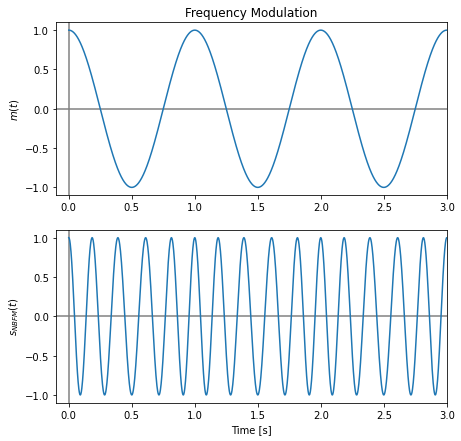

In [18]:
# Define freqency deviation constant
kf = 0.5     # in Hz/V

# Define modulation index
beta = (kf/fm)*Am

# Define the FM signal
s_NBFM_t = Ac*np.cos(2*np.pi*fc*t+beta*np.sin(2.0*np.pi*fm*t))

# Plot the signal
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Frequency Modulation')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,m_t)
plt.xlim(-0.1,3)
plt.ylabel('$m(t)$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.plot(t,s_NBFM_t)
plt.xlim(-0.1,3)
plt.ylabel('$s_{NBFM}(t)$')

plt.xlabel('Time [s]')
plt.show()

### Fourier transform of the NBFM signal
The Fourier transform of the NBFM signal is expressed as
$$
S_{NBFM}(f) = \dfrac{A_{c}}{2}\delta(f\pm f_{c})-\dfrac{\beta A_{c}}{4}\delta(f\pm [f_{c}-f_{m}]) + \dfrac{\beta A_{c}}{4}\delta(f\pm [f_{c}+f_{m}])
$$

#### Compare with Fourier transform of DSB-AM
The DSB-AM signal will have a similar Fourier transform as shown below:
$$
S_{DSB-AM}(f) = \dfrac{A_{c}}{2}\delta(f\pm f_{c})+\dfrac{k_{a}A_{c}}{4}\delta(f\pm [f_{c}-f_{m}]) + \dfrac{k_{a}A_{c}}{4}\delta(f\pm [f_{c}+f_{m}])
$$
where $k_{a}$ is the amplitude sensitivity factor.

The phase reversal of the lower sideband line in NBFM produces a quadrature component, which creates FM instead of AM.

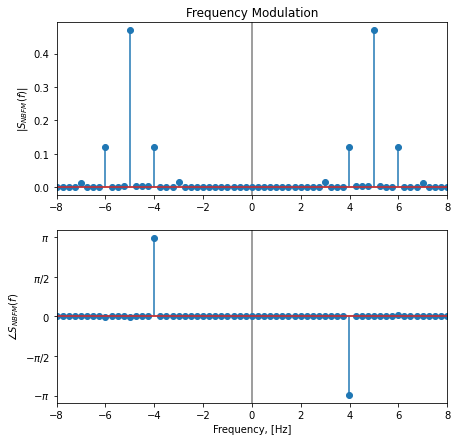

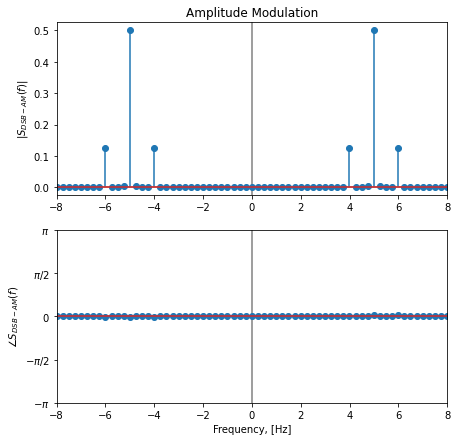

In [19]:
# Calculate FFT. 
M_f = np.fft.fftshift(np.fft.fft(m_t)/N)                # message signal
S_NBFM_f = np.fft.fftshift(np.fft.fft(s_NBFM_t)/N)      # modulated signal

# Determine phase only where amplitude is non-zero
S_NBFM_f_phase = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_NBFM_f[i])>0.1:
        S_NBFM_f_phase[i] = np.angle(S_NBFM_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Frequency Modulation')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(S_NBFM_f))
plt.xlim(-8,8)
plt.ylabel('$|S_{NBFM}(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_NBFM_f_phase)
plt.xlim(-8,8)
plt.ylabel('$\\angle{S_{NBFM}(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

# Compare with AM
# Define the amplitude sensitivity constant
ka = 0.5

# Define the amplitude modulated signal
s_AM_t = (1+ka*m_t)*Ac*np.cos(2*np.pi*fc*t)

# Calculate FFT. 
S_AM_f = np.fft.fftshift(np.fft.fft(s_AM_t)/N)      # modulated signal

# Determine phase only where amplitude is non-zero
S_AM_f_phase = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_AM_f[i])>0.1:
        S_AM_f_phase[i] = np.angle(S_AM_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Amplitude Modulation')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(S_AM_f))
plt.xlim(-8,8)
plt.ylabel('$|S_{DSB-AM}(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_AM_f_phase)
plt.xlim(-8,8)
plt.ylabel('$\\angle{S_{DSB-AM}(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

## General definition of an angle modulated signal

### Bessel function
In general, the FM signal is given as
$$
s_{FM}(t) = A_{c}\cos[2\pi f_{c}t + \beta\sin(2\pi f_{m}t)]
$$
which can then be given using Bessel function as 
$$
s_{FM}(t) = A_{c}\sum_{n=-\infty}^{\infty}J_{n}(\beta)\cos(2\pi[f_{c}+nf_{m}]t)
$$
where $J_{n}(\beta)$ is the Bessel function, $n$ is the sideband number, and $\beta$ is the modulation index.

#### Bessel function table

Bessel function is defined as
$$
J_{n}(\beta) = \dfrac{1}{2\pi}\int_{-\pi}^{\pi} e^{-j(n\theta-\beta\sin\theta)} d\theta
$$
The following table can be used to determine the value of $J_{n}(\beta)$ for a given value of $\beta$.

<img src="Bessel_Table.jpg" alt="Bessel_Table" style="zoom:50%;" />


## Narrowband (NBFM) approximation

Assume message signal frequency is $f_{m}=1\,\mathrm{Hz}$, and its amplitude is $A_{m}=1\,\mathrm{V}$.

Assume carrier signal frequency is $f_{c}=10\,\mathrm{Hz}$.

Assume, that frequency deviation constant, $k_{f} = 0.5\,\mathrm{Hz/V}$. Therefore,
$$
\beta = \dfrac{k_{f}}{f_{m}}A_{m} = 0.5
$$

Since $\beta\ll 1$, the following Bessel properties can be applied:
$$
\begin{align*}
J_{0}(\beta) &\approx 1\\
J_{1}(\beta) &\approx \dfrac{\beta}{2}\\
J_{-1}(\beta) &\approx \dfrac{-\beta}{2}\ \mathrm{since\ n=1\ is\ odd}\\
J_{n}(\beta) &\approx 0\ \mathrm{for\ all}\ |n|>1 
\end{align*}
$$

The NBFM signal can be written as
$$
\begin{align*}
s_{NBFM}(t) &= A_{c}\sum_{n=-1}^{1}J_{n}(\beta)\cos(2\pi[f_{c}+nf_{m}]t)\\
&= A_{c}\cos(2\pi f_{c}t) + \dfrac{A_{c}\beta}{2}\left(\cos(2\pi[f_{c}+f_{m}t])-\cos(2\pi[f_{c}-f_{m}])\right) 
\end{align*}
$$

#### Fourier transform of NBFM
$$
S_{NBFM}(f) = \dfrac{A_{c}}{2}\delta(f\pm f_{c})-\dfrac{A_{c}\beta}{4}\delta(f\pm [f_{c}-f_{m}])+\dfrac{A_{c}\beta}{4}\delta(f\pm [f_{c}+f_{m}])
$$

#### Bandwidth of NBFM
The bandwidth in this case is $B=2f_{m}=4\,\mathrm{Hz}$.

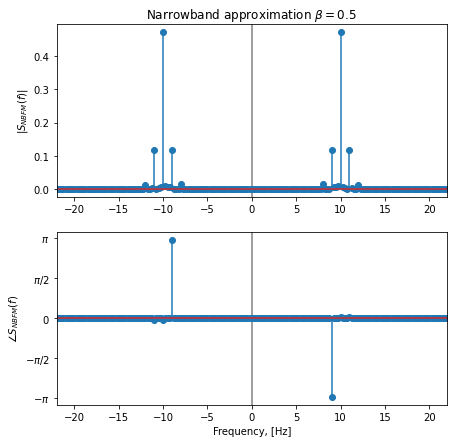

In [20]:
# Define message signal frequency
fm = 1

# Define carrier signal frequency
fc = 10

# Define freqency deviation constant
kf = 0.5     # in Hz/V

# Define modulation index
beta = (kf/fm)*Am

# Define the FM signal
s_NBFM_t = Ac*np.cos(2*np.pi*fc*t+beta*np.sin(2.0*np.pi*fm*t))

# Calculate FFT 
S_NBFM_f = np.fft.fftshift(np.fft.fft(s_NBFM_t)/N)

# Determine phase only where amplitude is non-zero
S_NBFM_f_phase = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_NBFM_f[i])>0.1:
        S_NBFM_f_phase[i] = np.angle(S_NBFM_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Narrowband approximation $\\beta=0.5$')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,np.abs(S_NBFM_f))
plt.xlim(-22,22)
plt.ylabel('$|S_{NBFM}(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_NBFM_f_phase)
plt.xlim(-22,22)
plt.ylabel('$\\angle{S_{NBFM}(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

## Wideband modulation

### Transmission bandwidth

For $\beta \gg 1$, the number of sidebands will increase. This increases the bandwidth required to transmitted the modulated signal.

Theoretically, the transmission bandwidth can be infinite because the number of sidebands can be infinite. However, practically only sidebands with significant power are considered. This makes the transmission bandwidth finite.

For a single tone message signal, the transmission bandwidth is defined as
$$
B_{T} = 2\,(\beta+1)\,f_{m}
$$
where $f_{m}$ is the frequency of the message signal.

### Transmitted power
#### Total transmitted power
The total average power for the FM signal can be defined as
$$
\begin{align*}
P_{total} &= \left<s^{2}_{FM}(t)\right>\\
&= \left<A^{2}_{c}\sum_{n=-\infty}^{\infty}J^{2}_{n}(\beta)\cos^{2}(2\pi[f_{c}+nf_{m}]t)\right>\\
&= A^{2}_{c}\sum_{n=-\infty}^{\infty}J^{2}_{n}(\beta)\left<\cos^{2}(2\pi[f_{c}+nf_{m}]t)\right>\\
&= A^{2}_{c}\sum_{n=-\infty}^{\infty}J^{2}_{n}(\beta)\left<\dfrac{1}{2}+\dfrac{1}{2}\cos(4\pi[f_{c}+nf_{m}]t)\right>\\
P_{total} &= \dfrac{1}{2}A^{2}_{c}\sum_{n=-\infty}^{\infty}J^{2}_{n}(\beta)
\end{align*}
$$
Bessel function has the property that
$$
\sum_{n=-\infty}^{\infty}J^{2}_{n}(\beta) = 1
$$
Therefore,
$$
P_{total} = \dfrac{1}{2}\,A^{2}_{c}
$$
This implies that the total transmitted power of a FM signal depends only on the carrier signal amplitude, $A_{c}$, provided that the signal has an infinite number sidebands.

#### Partial transmitted power
To determine the portion of the power contained in the sidebands, assume that the number of sidebands is limited to $k$. Then, the partial transmitted power can be defined as 
$$
P_{part} = \dfrac{1}{2}A^{2}_{c}\sum_{n=-k}^{k}J^{2}_{n}(\beta)
$$
#### Power ratio
The ratio of the partial transmitted power to the total transmitted power is defined as
$$
P_{r} = \dfrac{P_{part}}{P_{total}} = \sum_{n=-k}^{k}J^{2}_{n}(\beta)
$$
The number of sidebands, $k=\beta+1$, will result in a power ratio of $P_{r}\approx 0.98$. This is considered an acceptable value for transmitting an angle modulated signal with minimal distortion.

### Analyzing the frequency sprectrum for different values of $\beta$
#### For $\beta=2.41$,
The number of significant sidebands is
$$
\begin{align*}
k &= \beta + 1\\
&= 2.41 + 1\\
k &\approx 3
\end{align*}
$$

The following Bessel function values from the table can be applied
$$
\begin{align*}
J_{0}(\beta) &= 0\\
\\
J_{1}(\beta) &\approx 0.52\\
J_{-1}(\beta) &\approx -0.52\\
\\
J_{2}(\beta) &\approx 0.43\\
J_{-2}(\beta) &\approx 0.43\\
\\
J_{3}(\beta) &\approx 0.2\\
J_{-3}(\beta) &\approx -0.2\\
\\
J_{n}(\beta) &\approx 0\ \mathrm{for\ all}\ |n|>3 
\end{align*}
$$

The transmission bandwidth is
$$
\begin{align*}
B_{T} &= 2\,(\beta+1)\,f_{m}\\
&= 2\times(2.41+1)\times 1\\
B_{T} &\approx 6\,\mathrm{Hz}
\end{align*}
$$
The transmitted power ratio is
$$
\begin{align*}
P_{r} &= \sum_{n=-k}^{k}J^{2}_{n}(\beta)\\
&= \sum_{n=-3}^{3}J^{2}_{n}(\beta)\\
&= J^{2}_{0}(\beta) + 2\sum_{n=1}^{3}J^{2}_{n}(\beta)\\
&= J^{2}_{0}(\beta) + 2\left[J^{2}_{1}(\beta)+J^{2}_{2}(\beta)+J^{2}_{3}(\beta)\right]\\
&= 0 + 2\left[(0.52)^{2}+(0.43)^{2}+(0.2)^{2}\right]\\
P_{r} &\approx 0.99
\end{align*}
$$

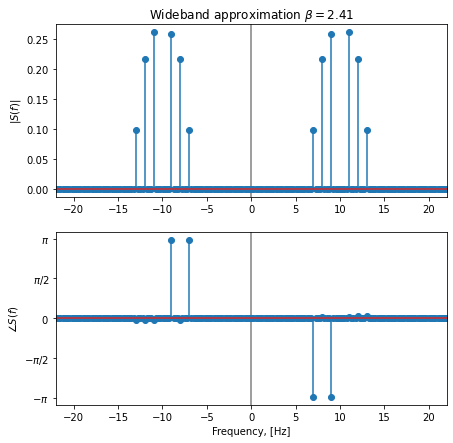

In [21]:
# Define message signal frequency
fm = 1

# Define carrier signal frequency
fc = 10

# Define freqency deviation constant
kf = 2.41    # in Hz/V

# Define modulation index
beta = (kf/fm)*Am

# Define the FM signal
s_t = Ac*np.cos(2*np.pi*fc*t+beta*np.sin(2.0*np.pi*fm*t))

# Calculate FFT 
S_f = np.fft.fftshift(np.fft.fft(s_t)/N)  

# Determine phase only where amplitude is non-zero
S_f_phase = np.zeros(len(freq))
S_f_mag = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_f[i])>0.05:
        S_f_phase[i] = np.angle(S_f[i])
        S_f_mag[i] = np.abs(S_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Wideband approximation $\\beta=2.41$')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_mag)
plt.xlim(-22,22)
plt.ylabel('$|S(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_phase)
plt.xlim(-22,22)
plt.ylabel('$\\angle{S(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

#### For $\beta=3$,
The number of significant sidebands is
$$
\begin{align*}
k &= \beta + 1\\
&= 3 + 1\\
k &= 4
\end{align*}
$$

The following Bessel function values from the table can be applied
$$
\begin{align*}
J_{0}(\beta) &\approx -0.26\\
\\
J_{1}(\beta) &\approx 0.34\\
J_{-1}(\beta) &\approx -0.34\\
\\
J_{2}(\beta) &\approx 0.49\\
J_{-2}(\beta) &\approx 0.49\\
\\
J_{3}(\beta) &\approx 0.31\\
J_{-3}(\beta) &\approx -0.31\\
\\
J_{4}(\beta) &\approx 0.13\\
J_{-4}(\beta) &\approx 0.13\\
\\
J_{n}(\beta) &\approx 0\ \mathrm{for\ all}\ |n|>4 
\end{align*}
$$

The transmission bandwidth is
$$
\begin{align*}
B_{T} &= 2\,(\beta+1)\,f_{m}\\
&= 2\times(3+1)\times 1\\
B_{T} &= 8\,\mathrm{Hz}
\end{align*}
$$
The transmitted power ratio is
$$
\begin{align*}
P_{r} &= \sum_{n=-k}^{k}J^{2}_{n}(\beta)\\
&= \sum_{n=-4}^{4}J^{2}_{n}(\beta)\\
&= J^{2}_{0}(\beta) + 2\sum_{n=1}^{4}J^{2}_{n}(\beta)\\
&= J^{2}_{0}(\beta) + 2\left[J^{2}_{1}(\beta)+J^{2}_{2}(\beta)+J^{2}_{3}(\beta)+J^{2}_{4}(\beta)\right]\\
&= (-0.26)^{2} + 2\left[(0.34)^{2}+(0.49)^{2}+(0.31)^{2}+(0.13)^{2}\right]\\
P_{r} &\approx 1
\end{align*}
$$

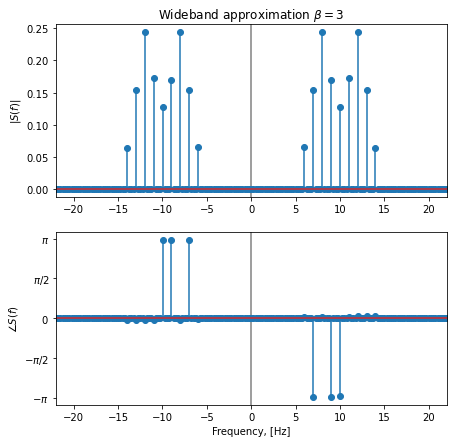

In [22]:
# Define message signal frequency
fm = 1

# Define carrier signal frequency
fc = 10

# Define freqency deviation constant
kf = 3    # in Hz/V

# Define modulation index
beta = (kf/fm)*Am

# Define the FM signal
s_t = Ac*np.cos(2*np.pi*fc*t+beta*np.sin(2.0*np.pi*fm*t))

# Calculate FFT 
S_f = np.fft.fftshift(np.fft.fft(s_t)/N)  

# Determine phase only where amplitude is non-zero
S_f_phase = np.zeros(len(freq))
S_f_mag = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_f[i])>0.05:
        S_f_phase[i] = np.angle(S_f[i])
        S_f_mag[i] = np.abs(S_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Wideband approximation $\\beta=3$')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_mag)
plt.xlim(-22,22)
plt.ylabel('$|S(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_phase)
plt.xlim(-22,22)
plt.ylabel('$\\angle{S(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

#### For $\beta=6$,
The number of significant sidebands is
$$
\begin{align*}
k &= \beta + 1\\
&= 6 + 1\\
k &= 7
\end{align*}
$$

The following Bessel function values from the table can be applied
$$
\begin{align*}
J_{0}(\beta) &\approx 0.15\\
\\
J_{1}(\beta) &\approx -0.28\\
J_{-1}(\beta) &\approx 0.28\\
\\
J_{2}(\beta) &\approx -0.24\\
J_{-2}(\beta) &\approx -0.24\\
\\
J_{3}(\beta) &\approx 0.11\\
J_{-3}(\beta) &\approx -0.11\\
\\
J_{4}(\beta) &\approx 0.36\\
J_{-4}(\beta) &\approx 0.36\\
\\
J_{5}(\beta) &\approx 0.36\\
J_{-5}(\beta) &\approx -0.36\\
\\
J_{6}(\beta) &\approx 0.25\\
J_{-6}(\beta) &\approx 0.25\\
\\
J_{7}(\beta) &\approx 0.13\\
J_{-7}(\beta) &\approx -0.13\\
\\
J_{n}(\beta) &\approx 0\ \mathrm{for\ all}\ |n|>7
\end{align*}
$$

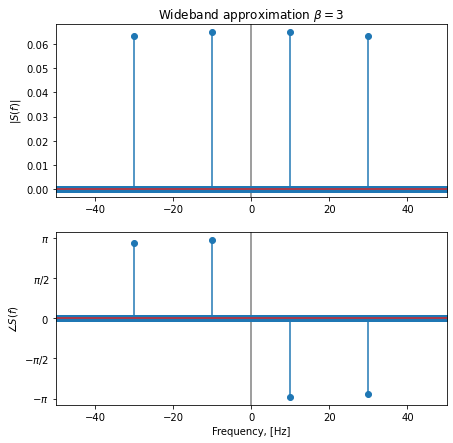

In [23]:
# Define message signal frequency
fm = 5

# Define carrier signal frequency
fc = 20

# Define freqency deviation constant
kf = 10    # in Hz/V
Ac = -0.26
Am = 1.5

# Define modulation index
beta = (kf/fm)*Am

# Define the FM signal
s_t = Ac*np.cos(2*np.pi*fc*t+beta*np.sin(2.0*np.pi*fm*t))

# Calculate FFT 
S_f = np.fft.fftshift(np.fft.fft(s_t)/N)  

# Determine phase only where amplitude is non-zero
S_f_phase = np.zeros(len(freq))
S_f_mag = np.zeros(len(freq))
for i in range(len(freq)):
    if np.abs(S_f[i])>0.05:
        S_f_phase[i] = np.angle(S_f[i])
        S_f_mag[i] = np.abs(S_f[i])


# Plot the magnitude spectrum
plt.figure(figsize=(7,7))
plt.subplot(211)
plt.title('Wideband approximation $\\beta=3$')
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_mag)
plt.xlim(-50,50)
plt.ylabel('$|S(f)|$')

plt.subplot(212)
plt.axvline(color='gray')
plt.axhline(color='gray')
plt.stem(freq,S_f_phase)
plt.xlim(-50,50)
plt.ylabel('$\\angle{S(f)}$')
my_yticks = ['$-\pi$','$-\pi/2$','$0$','$\pi/2$','$\pi$']   
plt.yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],my_yticks) 

plt.xlabel('Frequency, [Hz]')
plt.show()

## Transmission bandwidth for an arbitrary message signal
Consider an arbitrary message signal having a bandwidth of $W\,\mathrm{Hz}$.

To generate a FM signal, the peak frequency deviation required will be
$$
\Delta f = k_{f}\,|m(t)|_{max}
$$
where $|m(t)|_{max}$ is the peak value of the message signal.

The modulation index, $\beta$, is replaced by a deviation ratio defined as
$$
D = \dfrac{\Delta f}{W} = \dfrac{k_{f}}{W}|m(t)|_{max}
$$

The transmission bandwith is given as
$$
B_{T} = 2\,(D+1)\,W
$$